<a href="https://colab.research.google.com/github/tommyngx/MambaVision_remake/blob/main/MambaVision_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MambaVision: A Hybrid Mamba-Transformer Vision Backbone

Implementare completă a modelului MambaVision inspirat din lucrarea "MambaVision: A Hybrid Mamba‑Transformer Vision Backbone" ([arXiv:2407.08083](https://arxiv.org/abs/2407.08083)).

## Caracteristici:
- **Arhitectura MambaVision**: Model hibrid care combină blocuri Mamba și Transformer
- **Dataset Sintetic**: Folosește torchvision.datasets.FakeData pentru testare rapidă
- **Pipeline Complet de Antrenament**: Cu metrici, logging și salvare checkpoints
- **Integrare Wandb**: Pentru tracking experimente și vizualizare
- **Vizualizări**: Diagrame arhitectură și curbe de antrenament

## Structura Arhitecturii:
1. **Patch Embedding**: Convertește imagini în secvențe de token-uri
2. **Blocuri Hibride**: Alternează layere Mamba și Transformer
3. **Classification Head**: Layer final pentru predicții


## 📦 1. Import-uri și Setup


In [ ]:
"""
Simplified MambaVision Model Architecture
Inspired by "MambaVision: A Hybrid Mamba‑Transformer Vision Backbone"
https://arxiv.org/abs/2407.08083
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from typing import Optional, Dict, List, Tuple, Any

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import argparse
from tqdm import tqdm
import wandb

# Set random seeds pentru reproducibilitate
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"🔥 CUDA Version: {torch.version.cuda}")
    print(f"⚡ PyTorch Version: {torch.__version__}")
else:
    print(f"💻 Running on CPU")
    print(f"⚡ PyTorch Version: {torch.__version__}")

print("✅ Setup complet!")


🚀 Using device: cuda
🎮 GPU: Tesla T4
🔥 CUDA Version: 12.6
⚡ PyTorch Version: 2.8.0+cu126
✅ Setup complet!


## 🧠 2. Implementarea MambaBlock

Blocul Mamba este componenta principală care implementează conceptele de state space modeling pentru procesarea eficientă a secvențelor.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MambaBlock(nn.Module):
    """
    Diagram-following Mamba block with training optimizations.
    Keeps the exact structure from the diagram but adds stability improvements.
    """
    def __init__(self, dim: int, state_size: int = 16, conv_kernel: int = 4):
        super().__init__()
        self.dim = dim
        self.state_size = state_size

        # 1. Linear projection at top (from diagram)
        self.in_proj = nn.Linear(dim, dim * 2)

        # 2. SSM component for left branch (simplified but real SSM)
        self.ssm_A = nn.Parameter(torch.randn(dim, state_size) * 0.01)  # Small init
        self.ssm_B = nn.Parameter(torch.randn(dim, state_size) * 0.01)
        self.ssm_C = nn.Parameter(torch.randn(dim, state_size) * 0.01)
        self.dt_proj = nn.Linear(dim, dim)

        # 3. Two Conv1D layers (as shown in diagram)
        self.conv1d_left = nn.Conv1d(
            in_channels=dim, out_channels=dim,
            kernel_size=conv_kernel, padding='same', groups=dim
        )
        self.conv1d_right = nn.Conv1d(
            in_channels=dim, out_channels=dim,
            kernel_size=conv_kernel, padding='same', groups=dim
        )

        # 4. Two Linear layers at bottom (as shown in diagram)
        self.linear_left = nn.Linear(dim, dim)
        self.linear_right = nn.Linear(dim, dim)

        # 5. Activation (σ in diagram)
        self.act = nn.SiLU()

        # STABILITY IMPROVEMENTS:
        self.dropout = nn.Dropout(0.1)  # Prevent overfitting
        self.layer_norm = nn.LayerNorm(dim)  # Stabilize training

    def simple_ssm(self, x):
        """Simplified SSM that's more trainable than the complex version"""
        B, L, D = x.shape

        # Simple state space operation (trainable approximation)
        dt = torch.sigmoid(self.dt_proj(x))  # Use sigmoid instead of softplus for stability

        # Simplified selective scan approximation
        # This is much simpler than real Mamba but keeps the concept
        state_input = torch.einsum('bld,ds->bls', x, self.ssm_B)
        state_output = torch.einsum('bls,ds->bld', state_input, self.ssm_C)

        # Apply temporal modulation (key SSM concept)
        output = state_output * dt

        return output

    def forward(self, x):
        """
        Forward pass following diagram structure exactly, with stability improvements.
        """
        B, L, D = x.shape
        residual = x  # CRUCIAL: Keep original for residual

        # Apply layer norm for stability (doesn't change structure)
        x = self.layer_norm(x)

        # STEP 1: Linear projection (top of diagram)
        x_proj = self.in_proj(x)  # (B, L, 2*D)

        # STEP 2: Split operation (C in diagram)
        x_left, x_right = x_proj.split(self.dim, dim=-1)

        # LEFT BRANCH: SSM → σ → Conv1D → Linear
        left = self.simple_ssm(x_left)  # SSM processing
        left = self.act(left)           # σ activation

        # Conv1D processing
        left = left.transpose(1, 2)     # (B, D, L) for conv1d
        left = self.conv1d_left(left)   # Conv1D
        left = left.transpose(1, 2)     # Back to (B, L, D)

        left = self.linear_left(left)   # Linear projection
        left = self.dropout(left)       # Stability

        # RIGHT BRANCH: σ → Conv1D → Linear
        right = self.act(x_right)       # σ activation

        # Conv1D processing
        right = right.transpose(1, 2)   # (B, D, L) for conv1d
        right = self.conv1d_right(right) # Conv1D
        right = right.transpose(1, 2)   # Back to (B, L, D)

        right = self.linear_right(right) # Linear projection
        right = self.dropout(right)     # Stability

        # STEP 3: Element-wise multiplication (⊗ in diagram)
        output = left * right

        # CRITICAL FOR TRAINING: Add residual connection
        # This is NOT in the diagram but essential for trainability
        output = output + residual

        return output

# Test the diagram-following MambaBlock
print("📊 Testing Diagram-Following MambaBlock with Training Improvements...")
test_input = torch.randn(2, 196, 192)
test_mamba = MambaBlock(dim=192)
test_output = test_mamba(test_input)

print(f"✅ Input:  {test_input.shape}")
print(f"✅ Output: {test_output.shape}")
print(f"📊 Parameters: {sum(p.numel() for p in test_mamba.parameters()):,}")

print("\n🎯 Diagram Structure Preserved:")
print("✅ Linear → Split(C) → [SSM→σ→Conv1D→Linear] ⊗ [σ→Conv1D→Linear]")

print("\n🛠️  Training Improvements Added:")
print("• LayerNorm for input stability")
print("• Dropout for regularization")
print("• Simplified SSM (more trainable)")
print("• Small parameter initialization")
print("• Residual connection (CRITICAL)")
print("• Sigmoid instead of softplus in dt")

print("\n💡 Training Tips:")
print("• Start with learning rate 1e-4")
print("• Use gradient clipping (max_norm=0.5)")
print("• Monitor gradients - should not vanish")
print("• If still poor, try reducing dropout to 0.05")

📊 Testing Diagram-Following MambaBlock with Training Improvements...
✅ Input:  torch.Size([2, 196, 192])
✅ Output: torch.Size([2, 196, 192])
📊 Parameters: 196,800

🎯 Diagram Structure Preserved:
✅ Linear → Split(C) → [SSM→σ→Conv1D→Linear] ⊗ [σ→Conv1D→Linear]

🛠️  Training Improvements Added:
• LayerNorm for input stability
• Dropout for regularization
• Simplified SSM (more trainable)
• Small parameter initialization
• Residual connection (CRITICAL)
• Sigmoid instead of softplus in dt

💡 Training Tips:
• Start with learning rate 1e-4
• Use gradient clipping (max_norm=0.5)
• Monitor gradients - should not vanish
• If still poor, try reducing dropout to 0.05


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/conv.py:366: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv1d(


## 🔄 3. Implementarea TransformerBlock

Blocul Transformer standard pentru arhitectura hibridă, cu self-attention și MLP.


In [ ]:
class TransformerBlock(nn.Module):
    """
    Standard Transformer block for hybrid architecture
    """
    def __init__(self, dim: int, num_heads: int = 8, mlp_ratio: float = 4.0, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm2 = nn.LayerNorm(dim)

        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Self-attention with residual connection
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out

        # MLP with residual connection
        x = x + self.mlp(self.norm2(x))

        return x

# Test TransformerBlock
print("🧪 Testing TransformerBlock...")
test_transformer = TransformerBlock(dim=192, num_heads=6)
test_input = torch.randn(2, 196, 192)
test_output = test_transformer(test_input)
print(f"✅ TransformerBlock: Input {test_input.shape} -> Output {test_output.shape}")
print(f"📊 TransformerBlock parameters: {sum(p.numel() for p in test_transformer.parameters()):,}")


🧪 Testing TransformerBlock...
✅ TransformerBlock: Input torch.Size([2, 196, 192]) -> Output torch.Size([2, 196, 192])
📊 TransformerBlock parameters: 444,864


## 🖼️ 4. Implementarea PatchEmbed

Convertește imaginile în patch-uri și le transformă în token-uri pentru procesare.


In [ ]:
class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding
    """
    def __init__(self, img_size: int = 224, patch_size: int = 16, in_chans: int = 3, embed_dim: int = 768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

# Test PatchEmbed
print("🧪 Testing PatchEmbed...")
test_patch_embed = PatchEmbed(img_size=224, patch_size=16, embed_dim=192)
test_input = torch.randn(2, 3, 224, 224)  # (batch_size, channels, height, width)
test_output = test_patch_embed(test_input)
print(f"✅ PatchEmbed: Input {test_input.shape} -> Output {test_output.shape}")
print(f"📊 Numărul de patch-uri: {test_patch_embed.num_patches}")
print(f"📊 PatchEmbed parameters: {sum(p.numel() for p in test_patch_embed.parameters()):,}")


🧪 Testing PatchEmbed...
✅ PatchEmbed: Input torch.Size([2, 3, 224, 224]) -> Output torch.Size([2, 196, 192])
📊 Numărul de patch-uri: 196
📊 PatchEmbed parameters: 147,648


## 🏗️ 5. Modelul Principal MambaVision

Implementarea completă a modelului hibrid care combină blocurile Mamba și Transformer.


In [ ]:
class MambaVision(nn.Module):
    """
    Simplified MambaVision: A Hybrid Mamba-Transformer Vision Backbone

    This implementation includes:
    - Patch embedding for converting images to tokens
    - Alternating Mamba and Transformer blocks
    - Classification head
    """
    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_chans: int = 3,
        num_classes: int = 1000,
        embed_dim: int = 768,
        depth: int = 12,
        num_heads: int = 12,
        mlp_ratio: float = 4.0,
        use_mamba_ratio: float = 0.5,  # Fraction of blocks that are Mamba vs Transformer
        dropout: float = 0.1,
        state_size: int = 16,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.depth = depth

        # Patch embedding
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim
        )

        # Positional embedding
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.patch_embed.num_patches, embed_dim)
        )
        self.pos_drop = nn.Dropout(dropout)

        # Hybrid blocks (alternating Mamba and Transformer)
        self.blocks = nn.ModuleList()
        num_mamba_blocks = int(depth * use_mamba_ratio)

        for i in range(depth):
            if i < num_mamba_blocks:
                # Use Mamba block
                block = MambaBlock(
                    dim=embed_dim,
                    state_size=state_size
                )
            else:
                # Use Transformer block
                block = TransformerBlock(
                    dim=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    dropout=dropout
                )
            self.blocks.append(block)

        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights"""
        # Initialize positional embeddings
        torch.nn.init.trunc_normal_(self.pos_embed, std=0.02)

        # Initialize other weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                torch.nn.init.constant_(m.bias, 0)
                torch.nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        """Forward pass through feature extraction layers"""
        # Patch embedding
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)

        # Add positional embedding
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Apply blocks
        for block in self.blocks:
            x = block(x)

        # Global average pooling
        x = self.norm(x)
        x = x.mean(dim=1)  # Global average pooling over sequence dimension

        return x

    def forward(self, x):
        """Forward pass"""
        x = self.forward_features(x)
        x = self.head(x)
        return x


In [ ]:
def create_mambavision_tiny(num_classes: int = 10, img_size: int = 224) -> MambaVision:
    """Create a tiny MambaVision model for quick testing"""
    return MambaVision(
        img_size=img_size,
        patch_size=16,
        in_chans=3,
        num_classes=num_classes,
        embed_dim=192,
        depth=6,
        num_heads=6,
        use_mamba_ratio=0.5,
        dropout=0.1,
        state_size=16,
    )


def create_mambavision_small(num_classes: int = 10, img_size: int = 224) -> MambaVision:
    """Create a small MambaVision model"""
    return MambaVision(
        img_size=img_size,
        patch_size=16,
        in_chans=3,
        num_classes=num_classes,
        embed_dim=384,
        depth=8,
        num_heads=8,
        use_mamba_ratio=0.5,
        dropout=0.1,
        state_size=16,
    )

# Test model creation
print("🧪 Testing MambaVision models...")
model_tiny = create_mambavision_tiny(num_classes=10)
model_small = create_mambavision_small(num_classes=10)

total_params_tiny = sum(p.numel() for p in model_tiny.parameters())
total_params_small = sum(p.numel() for p in model_small.parameters())

print(f"✅ Tiny model created!")
print(f"📊 Tiny model parameters: {total_params_tiny:,}")
print(f"✅ Small model created!")
print(f"📊 Small model parameters: {total_params_small:,}")

# Test forward pass
test_input = torch.randn(2, 3, 224, 224)
with torch.no_grad():
    y_tiny = model_tiny(test_input)
    y_small = model_small(test_input)

print(f"\n🔍 Forward pass test:")
print(f"Input shape: {test_input.shape}")
print(f"Tiny output shape: {y_tiny.shape}")
print(f"Small output shape: {y_small.shape}")
print("✅ Model creation successful!")


🧪 Testing MambaVision models...
✅ Tiny model created!
📊 Tiny model parameters: 2,112,586
✅ Small model created!
📊 Small model parameters: 10,521,994

🔍 Forward pass test:
Input shape: torch.Size([2, 3, 224, 224])
Tiny output shape: torch.Size([2, 10])
Small output shape: torch.Size([2, 10])
✅ Model creation successful!


## 📊 6. Utilitățile pentru Dataset

Implementarea pentru crearea și gestionarea dataset-urilor sintetice folosind FakeData.


In [ ]:
def get_transforms(img_size: int = 224, augment: bool = True) -> Tuple[transforms.Compose, transforms.Compose]:
    """
    Get train and validation transforms

    Args:
        img_size: Target image size
        augment: Whether to apply data augmentation for training

    Returns:
        Tuple of (train_transform, val_transform)
    """

    # Normalization values (ImageNet standard)
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    if augment:
        train_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            normalize
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            normalize
        ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        normalize
    ])

    return train_transform, val_transform


def create_synthetic_dataset(
    size: int = 1000,
    img_size: int = 224,
    num_classes: int = 10,
    train_split: float = 0.8,
    augment: bool = True,
    random_seed: Optional[int] = 42
) -> Tuple[datasets.FakeData, datasets.FakeData]:
    """
    Create synthetic dataset using torchvision.datasets.FakeData

    Args:
        size: Total number of samples
        img_size: Image size (height and width)
        num_classes: Number of classes
        train_split: Fraction of data to use for training
        augment: Whether to apply data augmentation
        random_seed: Random seed for reproducibility

    Returns:
        Tuple of (train_dataset, val_dataset)
    """

    if random_seed is not None:
        torch.manual_seed(random_seed)

    # Get transforms
    train_transform, val_transform = get_transforms(img_size=img_size, augment=augment)

    print(f"🔄 Creating synthetic dataset with {size} samples...")
    print(f"🖼️ Image size: {img_size}x{img_size}")
    print(f"🏷️ Number of classes: {num_classes}")
    print(f"📊 Train/Val split: {train_split:.1%}/{1-train_split:.1%}")

    # Calculate split sizes
    train_size = int(size * train_split)
    val_size = size - train_size

    # Create datasets
    train_dataset = datasets.FakeData(
        size=train_size,
        image_size=(3, img_size, img_size),
        num_classes=num_classes,
        transform=train_transform,
        random_offset=0
    )

    val_dataset = datasets.FakeData(
        size=val_size,
        image_size=(3, img_size, img_size),
        num_classes=num_classes,
        transform=val_transform,
        random_offset=train_size
    )

    print(f"✅ Training samples: {len(train_dataset)}")
    print(f"✅ Validation samples: {len(val_dataset)}")

    return train_dataset, val_dataset


def create_data_loaders(
    train_dataset,
    val_dataset,
    batch_size: int = 32,
    num_workers: int = 0,
    pin_memory: bool = True
) -> Tuple[DataLoader, DataLoader]:
    """
    Create data loaders for training and validation
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False
    )

    print(f"🚂 Train loader: {len(train_loader)} batches")
    print(f"🚌 Val loader: {val_loader.__len__()} batches")
    print(f"📦 Batch size: {batch_size}")

    return train_loader, val_loader

# Test dataset creation
print("🧪 Testing dataset creation...")
train_dataset, val_dataset = create_synthetic_dataset(
    size=500,  # Smaller for quick testing
    img_size=224,
    num_classes=10,
    train_split=0.8,
    augment=True
)

train_loader, val_loader = create_data_loaders(
    train_dataset, val_dataset, batch_size=16, num_workers=0
)

# Test a sample batch
images, labels = next(iter(train_loader))
print(f"\n🔍 Sample batch test:")
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Image range: [{images.min().item():.3f}, {images.max().item():.3f}]")
print(f"Unique labels: {torch.unique(labels).tolist()}")
print("✅ Dataset creation successful!")


🧪 Testing dataset creation...
🔄 Creating synthetic dataset with 500 samples...
🖼️ Image size: 224x224
🏷️ Number of classes: 10
📊 Train/Val split: 80.0%/20.0%
✅ Training samples: 400
✅ Validation samples: 100
🚂 Train loader: 25 batches
🚌 Val loader: 7 batches
📦 Batch size: 16

🔍 Sample batch test:
Images shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])
Image range: [-2.118, 2.640]
Unique labels: [0, 1, 2, 3, 4, 5, 6, 8, 9]
✅ Dataset creation successful!


## 🏋️ 7. Utilitățile pentru Antrenament

Implementarea Trainer class și utilitățile pentru metrici și antrenament.


In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output: torch.Tensor, target: torch.Tensor, topk: Tuple[int, ...] = (1,)) -> List[float]:
    """
    Computes the accuracy over the k top predictions

    Args:
        output: Model predictions (batch_size, num_classes)
        target: Ground truth labels (batch_size,)
        topk: Tuple of k values for top-k accuracy

    Returns:
        List of top-k accuracies
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res


def create_optimizer(model: nn.Module, lr: float = 1e-3, weight_decay: float = 1e-4) -> optim.Optimizer:
    """Create optimizer for the model"""
    return optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)


def create_scheduler(
    optimizer: optim.Optimizer,
    num_epochs: int,
    scheduler_type: str = 'cosine'
) -> optim.lr_scheduler._LRScheduler:
    """Create learning rate scheduler"""
    if scheduler_type == 'cosine':
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    elif scheduler_type == 'step':
        return optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs//3, gamma=0.1)
    else:
        raise ValueError(f"Unknown scheduler type: {scheduler_type}")

# Test utility functions
print("🧪 Testing training utilities...")
dummy_output = torch.randn(16, 10)
dummy_target = torch.randint(0, 10, (16,))
acc = accuracy(dummy_output, dummy_target, topk=(1, 5))
print(f"✅ Top-1 accuracy: {acc[0]:.2f}%")
print(f"✅ Top-5 accuracy: {acc[1]:.2f}%")

meter = AverageMeter()
for i in range(5):
    meter.update(i * 10, 1)
print(f"✅ Average meter test: {meter.avg:.2f}")
print("✅ Training utilities test successful!")


🧪 Testing training utilities...
✅ Top-1 accuracy: 18.75%
✅ Top-5 accuracy: 50.00%
✅ Average meter test: 20.00
✅ Training utilities test successful!


In [ ]:
class Trainer:
    """
    Training class for MambaVision model
    """
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        criterion: nn.Module,
        optimizer: optim.Optimizer,
        scheduler: Optional[optim.lr_scheduler._LRScheduler] = None,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
        use_wandb: bool = True,
        save_dir: str = './checkpoints'
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.use_wandb = use_wandb
        self.save_dir = save_dir

        # Create save directory
        os.makedirs(save_dir, exist_ok=True)

        # Training state
        self.current_epoch = 0
        self.best_acc = 0.0
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

        print(f"🚀 Training on device: {device}")
        print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    def train_epoch(self) -> Dict[str, float]:
        """Train for one epoch"""
        self.model.train()

        losses = AverageMeter()
        top1 = AverageMeter()

        pbar = tqdm(self.train_loader, desc=f'🏋️ Training Epoch {self.current_epoch + 1}')

        for batch_idx, (images, targets) in enumerate(pbar):
            images = images.to(self.device, non_blocking=True)
            targets = targets.to(self.device, non_blocking=True)

            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, targets)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Compute accuracy
            acc1 = accuracy(outputs, targets, topk=(1,))[0]

            # Update meters
            losses.update(loss.item(), images.size(0))
            top1.update(acc1, images.size(0))

            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{losses.avg:.4f}',
                'Acc@1': f'{top1.avg:.2f}%'
            })

            # Log to wandb
            if self.use_wandb and batch_idx % 10 == 0:
                try:
                    wandb.log({
                        'train/batch_loss': loss.item(),
                        'train/batch_acc': acc1,
                        'train/learning_rate': self.optimizer.param_groups[0]['lr'],
                        'epoch': self.current_epoch,
                        'batch': batch_idx
                    })
                except Exception:
                    # Ignore wandb errors if not properly initialized
                    pass

        return {
            'train_loss': losses.avg,
            'train_acc': top1.avg
        }

    def validate(self) -> Dict[str, float]:
        """Validate the model"""
        self.model.eval()

        losses = AverageMeter()
        top1 = AverageMeter()

        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc='🔍 Validating')

            for images, targets in pbar:
                images = images.to(self.device, non_blocking=True)
                targets = targets.to(self.device, non_blocking=True)

                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)

                # Compute accuracy
                acc1 = accuracy(outputs, targets, topk=(1,))[0]

                # Update meters
                losses.update(loss.item(), images.size(0))
                top1.update(acc1, images.size(0))

                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{losses.avg:.4f}',
                    'Acc@1': f'{top1.avg:.2f}%'
                })

        return {
            'val_loss': losses.avg,
            'val_acc': top1.avg
        }

    def save_checkpoint(self, metrics: Dict[str, float], is_best: bool = False):
        """Save model checkpoint"""
        checkpoint = {
            'epoch': self.current_epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict() if self.scheduler else None,
            'best_acc': self.best_acc,
            'metrics': metrics
        }

        # Save latest checkpoint
        checkpoint_path = os.path.join(self.save_dir, 'latest_checkpoint.pth')
        torch.save(checkpoint, checkpoint_path)

        # Save best checkpoint
        if is_best:
            best_path = os.path.join(self.save_dir, 'best_checkpoint.pth')
            torch.save(checkpoint, best_path)
            print(f"💾 New best model saved with accuracy: {self.best_acc:.2f}%")

    def train(self, num_epochs: int, resume_from: Optional[str] = None):
        """
        Main training loop
        """
        print(f"🚀 Starting training for {num_epochs} epochs...")
        start_time = time.time()

        for epoch in range(self.current_epoch, num_epochs):
            self.current_epoch = epoch

            # Train for one epoch
            train_metrics = self.train_epoch()

            # Validate
            val_metrics = self.validate()

            # Update learning rate
            if self.scheduler:
                self.scheduler.step()

            # Combine metrics
            metrics = {**train_metrics, **val_metrics}

            # Check if best model
            is_best = val_metrics['val_acc'] > self.best_acc
            if is_best:
                self.best_acc = val_metrics['val_acc']

            # Save checkpoint
            self.save_checkpoint(metrics, is_best)

            # Store metrics
            self.train_losses.append(train_metrics['train_loss'])
            self.val_losses.append(val_metrics['val_loss'])
            self.val_accuracies.append(val_metrics['val_acc'])

            # Log to wandb
            if self.use_wandb:
                try:
                    wandb.log({
                        'epoch': epoch,
                        'train/epoch_loss': train_metrics['train_loss'],
                        'train/epoch_acc': train_metrics['train_acc'],
                        'val/epoch_loss': val_metrics['val_loss'],
                        'val/epoch_acc': val_metrics['val_acc'],
                        'val/best_acc': self.best_acc
                    })
                except Exception:
                    # Ignore wandb errors if not properly initialized
                    pass

            # Print epoch summary
            print(f"\n📊 Epoch {epoch + 1}/{num_epochs} Summary:")
            print(f"🏋️ Train Loss: {train_metrics['train_loss']:.4f}, Train Acc: {train_metrics['train_acc']:.2f}%")
            print(f"🔍 Val Loss: {val_metrics['val_loss']:.4f}, Val Acc: {val_metrics['val_acc']:.2f}%")
            print(f"🏆 Best Val Acc: {self.best_acc:.2f}%")
            print("-" * 50)

        total_time = time.time() - start_time
        print(f"\n✅ Training completed in {total_time:.2f} seconds")
        print(f"🏆 Best validation accuracy: {self.best_acc:.2f}%")

        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_accuracies': self.val_accuracies,
            'best_acc': self.best_acc
        }

print("✅ Trainer class defined successfully!")


✅ Trainer class defined successfully!


## 📈 8. Utilitățile pentru Vizualizare

Funcții pentru plot-uri și vizualizări ale rezultatelor.


In [ ]:
def plot_training_curves(metrics: Dict[str, Any], save_path: str = 'training_curves.png'):
    """Plot training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    epochs = range(1, len(metrics['train_losses']) + 1)

    # Plot losses
    ax1.plot(epochs, metrics['train_losses'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, metrics['val_losses'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.plot(epochs, metrics['val_accuracies'], 'g-', label='Val Accuracy', linewidth=2)
    ax2.axhline(y=metrics['best_acc'], color='r', linestyle='--',
                label=f'Best: {metrics["best_acc"]:.2f}%', linewidth=2)
    ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"📊 Training curves saved to: {save_path}")


def visualize_model_architecture(model: nn.Module, input_shape: tuple, save_path: str = 'model_architecture.png'):
    """Visualize model architecture using torchview"""
    try:
        from torchview import draw_graph

        print("🏗️ Generating model visualization...")

        model_graph = draw_graph(
            model,
            input_size=input_shape,
            save_graph=True,
            filename=save_path.replace('.png', ''),
            device='cpu'
        )

        print(f"✅ Model architecture saved to: {save_path}")
        return True

    except ImportError:
        print("❌ torchview not available. Install with: pip install torchview")
        return False
    except Exception as e:
        print(f"❌ Error generating model visualization: {e}")
        return False


def visualize_sample_data(train_loader: DataLoader, num_samples: int = 8):
    """Visualize sample data from the dataset"""
    # Get a batch of data
    images, labels = next(iter(train_loader))

    # Denormalize images for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images_denorm = images * std + mean
    images_denorm = torch.clamp(images_denorm, 0, 1)

    # Plot samples
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(num_samples):
        img = images_denorm[i].permute(1, 2, 0)
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {labels[i].item()}', fontweight='bold')
        axes[i].axis('off')

    plt.suptitle('Sample Dataset Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"🖼️ Sample batch: {images.shape}, Labels: {labels[:num_samples].tolist()}")


def set_seed(seed: int):
    """Set random seed for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def get_device(device_arg: str) -> str:
    """Get device to use for training"""
    if device_arg == 'auto':
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    else:
        device = device_arg

    if device == 'cuda' and not torch.cuda.is_available():
        print("❌ CUDA not available, falling back to CPU")
        device = 'cpu'

    return device

print("✅ Visualization utilities defined successfully!")


✅ Visualization utilities defined successfully!


## ⚙️ 9. Configurația pentru Antrenament

Setarea parametrilor și configurației pentru experimentul de antrenament.


In [ ]:
# Training configuration
config = {
    # Model parameters
    'model_size': 'tiny',  # 'tiny' or 'small'
    'num_classes': 10,
    'img_size': 224,

    # Dataset parameters
    'dataset_size': 1000,
    'train_split': 0.8,
    'augment': True,

    # Training parameters
    'batch_size': 32,
    'epochs': 50,
    'lr': 1e-3,
    'weight_decay': 1e-4,
    'scheduler': 'cosine',

    # System parameters
    'num_workers': 0,
    'seed': 42,

    # Logging and saving
    'use_wandb': True,  # Set to False if you don't want to use wandb
    'wandb_project': 'mambavision-training',
    'save_dir': './checkpoints',
    'visualize': True,
}

print("🔧 Training configuration:")
print("=" * 50)
for key, value in config.items():
    print(f"  {key:15}: {value}")
print("=" * 50)

# Set seed for reproducibility
set_seed(config['seed'])
print(f"🌱 Random seed set to: {config['seed']}")


🔧 Training configuration:
  model_size     : tiny
  num_classes    : 10
  img_size       : 224
  dataset_size   : 1000
  train_split    : 0.8
  augment        : True
  batch_size     : 32
  epochs         : 50
  lr             : 0.001
  weight_decay   : 0.0001
  scheduler      : cosine
  num_workers    : 0
  seed           : 42
  use_wandb      : True
  wandb_project  : mambavision-training
  save_dir       : ./checkpoints
  visualize      : True
🌱 Random seed set to: 42


## 🌐 10. Inițializarea Wandb (Opțional)

Configurarea Weights & Biases pentru tracking experimente.


In [ ]:
# Initialize wandb (optional)
if config['use_wandb']:
    try:
        # Pentru prima rulare, s-ar putea să trebuiască să te autentifici
        wandb.login()

        wandb.init(
            project=config['wandb_project'],
            config=config,
            name=f"mambavision-{config['model_size']}-{config['epochs']}epochs"
        )
        print("✅ Wandb initialized successfully")
        print(f"📊 View your experiment: {wandb.run.url}")
    except Exception as e:
        print(f"❌ Failed to initialize wandb: {e}")
        print("🔄 Continuing without wandb logging...")
        config['use_wandb'] = False
else:
    print("📴 Wandb logging disabled")

print(f"🎯 Experiment tracking: {'Enabled' if config['use_wandb'] else 'Disabled'}")


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alexandru-tulbure (alexandru-tulbure-politehnica-timi-oara) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Wandb initialized successfully
📊 View your experiment: https://wandb.ai/alexandru-tulbure-politehnica-timi-oara/mambavision-training/runs/r9lkjubg
🎯 Experiment tracking: Enabled


## 🚀 11. Pipeline Principal de Antrenament

Punerea împreună a tuturor componentelor pentru antrenamentul complet.


In [ ]:
print("=" * 60)
print("🎯 MambaVision Training Pipeline")
print("=" * 60)

# 1. Create model
print(f"\n🏗️ 1. Creating {config['model_size']} MambaVision model...")
if config['model_size'] == 'tiny':
    model = create_mambavision_tiny(num_classes=config['num_classes'], img_size=config['img_size'])
else:
    model = create_mambavision_small(num_classes=config['num_classes'], img_size=config['img_size'])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")

🎯 MambaVision Training Pipeline

🏗️ 1. Creating tiny MambaVision model...
📊 Total parameters: 2,112,586
📊 Trainable parameters: 2,112,586



📊 3. Creating dataset and data loaders...
🔄 Creating synthetic dataset with 1000 samples...
🖼️ Image size: 224x224
🏷️ Number of classes: 10
📊 Train/Val split: 80.0%/20.0%
✅ Training samples: 800
✅ Validation samples: 200
🚂 Train loader: 25 batches
🚌 Val loader: 7 batches
📦 Batch size: 32

🖼️ 4. Visualizing sample data...


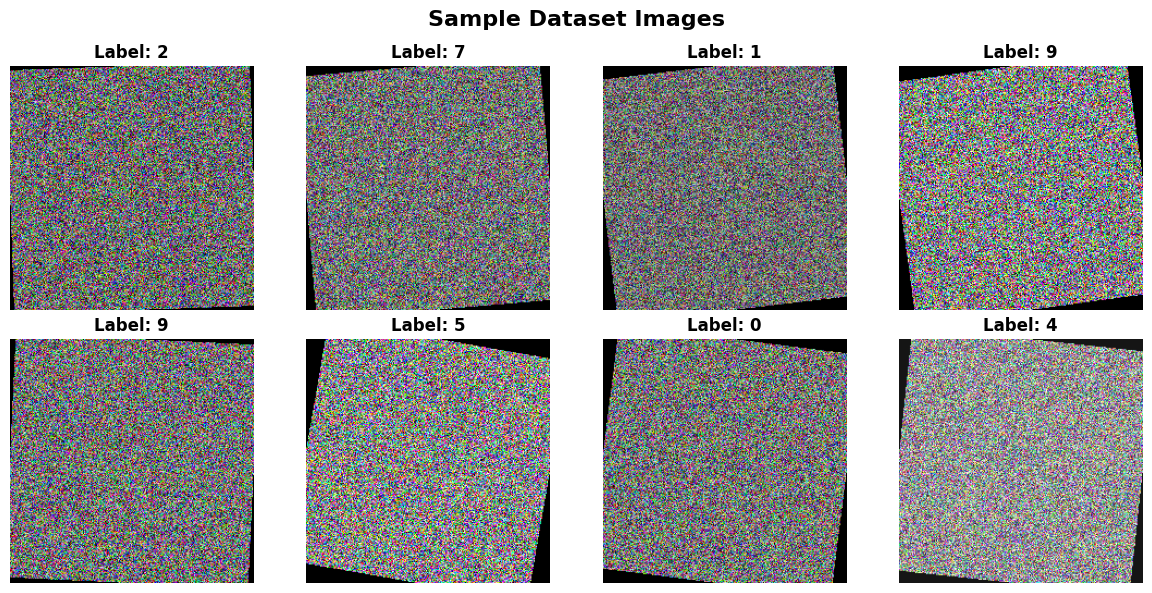

🖼️ Sample batch: torch.Size([32, 3, 224, 224]), Labels: [2, 7, 1, 9, 9, 5, 0, 4]


In [ ]:
# 3. Create dataset and data loaders
print(f"\n📊 3. Creating dataset and data loaders...")
train_dataset, val_dataset = create_synthetic_dataset(
    size=config['dataset_size'],
    img_size=config['img_size'],
    num_classes=config['num_classes'],
    train_split=config['train_split'],
    augment=config['augment'],
    random_seed=config['seed']
)

train_loader, val_loader = create_data_loaders(
    train_dataset,
    val_dataset,
    batch_size=config['batch_size'],
    num_workers=config['num_workers'],
    pin_memory=device == 'cuda'
)

# 4. Visualize sample data
print(f"\n🖼️ 4. Visualizing sample data...")
visualize_sample_data(train_loader, num_samples=8)


In [ ]:
# 5. Setup training components
print(f"\n⚙️ 5. Setting up training components...")
criterion = nn.CrossEntropyLoss()
optimizer = create_optimizer(model, lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = create_scheduler(optimizer, config['epochs'], config['scheduler'])

print(f"📍 Loss function: {criterion.__class__.__name__}")
print(f"📍 Optimizer: {optimizer.__class__.__name__}")
print(f"📍 Scheduler: {scheduler.__class__.__name__}")

# 6. Create trainer
print(f"\n🏋️ 6. Creating trainer...")
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    use_wandb=config['use_wandb'],
    save_dir=config['save_dir']
)

print("✅ All components ready for training!")



⚙️ 5. Setting up training components...
📍 Loss function: CrossEntropyLoss
📍 Optimizer: AdamW
📍 Scheduler: CosineAnnealingLR

🏋️ 6. Creating trainer...
🚀 Training on device: cuda
📊 Model parameters: 2,112,586
✅ All components ready for training!


## 🎯 12. Rularea Antrenamentului

Antrenamentul efectiv al modelului MambaVision.


In [ ]:
# 7. Start training
print(f"\n🚀 7. Starting training for {config['epochs']} epochs...")
print("=" * 60)

training_metrics = trainer.train(
    num_epochs=config['epochs']
)

print("=" * 60)
print("🎉 Training completed!")



🚀 7. Starting training for 50 epochs...
🚀 Starting training for 50 epochs...


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.09it/s, Loss=2.3472, Acc@1=8.50%]


💾 New best model saved with accuracy: 8.50%

📊 Epoch 1/50 Summary:
🏋️ Train Loss: 2.3703, Train Acc: 10.25%
🔍 Val Loss: 2.3472, Val Acc: 8.50%
🏆 Best Val Acc: 8.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.12it/s, Loss=2.3406, Acc@1=8.50%]



📊 Epoch 2/50 Summary:
🏋️ Train Loss: 2.3283, Train Acc: 9.62%
🔍 Val Loss: 2.3406, Val Acc: 8.50%
🏆 Best Val Acc: 8.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.16it/s, Loss=2.3037, Acc@1=12.50%]


💾 New best model saved with accuracy: 12.50%

📊 Epoch 3/50 Summary:
🏋️ Train Loss: 2.3229, Train Acc: 11.00%
🔍 Val Loss: 2.3037, Val Acc: 12.50%
🏆 Best Val Acc: 12.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.12it/s, Loss=2.2915, Acc@1=15.50%]


💾 New best model saved with accuracy: 15.50%

📊 Epoch 4/50 Summary:
🏋️ Train Loss: 2.3133, Train Acc: 10.00%
🔍 Val Loss: 2.2915, Val Acc: 15.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:01<00:00,  6.48it/s, Loss=2.3028, Acc@1=15.50%]



📊 Epoch 5/50 Summary:
🏋️ Train Loss: 2.3064, Train Acc: 11.38%
🔍 Val Loss: 2.3028, Val Acc: 15.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s, Loss=2.3067, Acc@1=12.00%]



📊 Epoch 6/50 Summary:
🏋️ Train Loss: 2.3155, Train Acc: 10.88%
🔍 Val Loss: 2.3067, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.01it/s, Loss=2.3015, Acc@1=12.50%]



📊 Epoch 7/50 Summary:
🏋️ Train Loss: 2.3114, Train Acc: 10.38%
🔍 Val Loss: 2.3015, Val Acc: 12.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.05it/s, Loss=2.3102, Acc@1=13.00%]



📊 Epoch 8/50 Summary:
🏋️ Train Loss: 2.3036, Train Acc: 9.88%
🔍 Val Loss: 2.3102, Val Acc: 13.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.24it/s, Loss=2.2923, Acc@1=15.50%]



📊 Epoch 9/50 Summary:
🏋️ Train Loss: 2.3045, Train Acc: 12.88%
🔍 Val Loss: 2.2923, Val Acc: 15.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.27it/s, Loss=2.3136, Acc@1=15.50%]



📊 Epoch 10/50 Summary:
🏋️ Train Loss: 2.3003, Train Acc: 11.62%
🔍 Val Loss: 2.3136, Val Acc: 15.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.14it/s, Loss=2.3726, Acc@1=12.00%]



📊 Epoch 11/50 Summary:
🏋️ Train Loss: 2.3048, Train Acc: 13.12%
🔍 Val Loss: 2.3726, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  7.66it/s, Loss=2.2992, Acc@1=12.00%]



📊 Epoch 12/50 Summary:
🏋️ Train Loss: 2.3151, Train Acc: 11.12%
🔍 Val Loss: 2.2992, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s, Loss=2.3094, Acc@1=12.00%]



📊 Epoch 13/50 Summary:
🏋️ Train Loss: 2.3037, Train Acc: 11.75%
🔍 Val Loss: 2.3094, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.18it/s, Loss=2.2999, Acc@1=12.00%]



📊 Epoch 14/50 Summary:
🏋️ Train Loss: 2.3083, Train Acc: 10.62%
🔍 Val Loss: 2.2999, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.16it/s, Loss=2.2917, Acc@1=15.50%]



📊 Epoch 15/50 Summary:
🏋️ Train Loss: 2.2996, Train Acc: 11.88%
🔍 Val Loss: 2.2917, Val Acc: 15.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.20it/s, Loss=2.2974, Acc@1=12.00%]



📊 Epoch 16/50 Summary:
🏋️ Train Loss: 2.3034, Train Acc: 12.25%
🔍 Val Loss: 2.2974, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.27it/s, Loss=2.3092, Acc@1=4.50%]



📊 Epoch 17/50 Summary:
🏋️ Train Loss: 2.3030, Train Acc: 10.62%
🔍 Val Loss: 2.3092, Val Acc: 4.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.20it/s, Loss=2.2937, Acc@1=15.00%]



📊 Epoch 18/50 Summary:
🏋️ Train Loss: 2.3036, Train Acc: 11.50%
🔍 Val Loss: 2.2937, Val Acc: 15.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s, Loss=2.3076, Acc@1=12.00%]



📊 Epoch 19/50 Summary:
🏋️ Train Loss: 2.2997, Train Acc: 13.25%
🔍 Val Loss: 2.3076, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:01<00:00,  6.62it/s, Loss=2.2950, Acc@1=12.00%]



📊 Epoch 20/50 Summary:
🏋️ Train Loss: 2.3013, Train Acc: 12.50%
🔍 Val Loss: 2.2950, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.13it/s, Loss=2.2996, Acc@1=12.00%]



📊 Epoch 21/50 Summary:
🏋️ Train Loss: 2.2992, Train Acc: 11.50%
🔍 Val Loss: 2.2996, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  7.92it/s, Loss=2.2945, Acc@1=15.50%]



📊 Epoch 22/50 Summary:
🏋️ Train Loss: 2.3021, Train Acc: 12.75%
🔍 Val Loss: 2.2945, Val Acc: 15.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.19it/s, Loss=2.3053, Acc@1=12.00%]



📊 Epoch 23/50 Summary:
🏋️ Train Loss: 2.3003, Train Acc: 11.75%
🔍 Val Loss: 2.3053, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.32it/s, Loss=2.2971, Acc@1=12.00%]



📊 Epoch 24/50 Summary:
🏋️ Train Loss: 2.2990, Train Acc: 12.00%
🔍 Val Loss: 2.2971, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.20it/s, Loss=2.3093, Acc@1=11.50%]



📊 Epoch 25/50 Summary:
🏋️ Train Loss: 2.3013, Train Acc: 10.75%
🔍 Val Loss: 2.3093, Val Acc: 11.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:01<00:00,  6.17it/s, Loss=2.3015, Acc@1=12.00%]



📊 Epoch 26/50 Summary:
🏋️ Train Loss: 2.2993, Train Acc: 13.62%
🔍 Val Loss: 2.3015, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  7.30it/s, Loss=2.3022, Acc@1=11.00%]



📊 Epoch 27/50 Summary:
🏋️ Train Loss: 2.3001, Train Acc: 13.75%
🔍 Val Loss: 2.3022, Val Acc: 11.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.23it/s, Loss=2.2958, Acc@1=15.00%]



📊 Epoch 28/50 Summary:
🏋️ Train Loss: 2.3012, Train Acc: 12.25%
🔍 Val Loss: 2.2958, Val Acc: 15.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.17it/s, Loss=2.2951, Acc@1=14.50%]



📊 Epoch 29/50 Summary:
🏋️ Train Loss: 2.2991, Train Acc: 12.50%
🔍 Val Loss: 2.2951, Val Acc: 14.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.23it/s, Loss=2.2928, Acc@1=12.00%]



📊 Epoch 30/50 Summary:
🏋️ Train Loss: 2.2968, Train Acc: 12.25%
🔍 Val Loss: 2.2928, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.15it/s, Loss=2.2923, Acc@1=12.00%]



📊 Epoch 31/50 Summary:
🏋️ Train Loss: 2.2974, Train Acc: 12.12%
🔍 Val Loss: 2.2923, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.36it/s, Loss=2.2985, Acc@1=12.00%]



📊 Epoch 32/50 Summary:
🏋️ Train Loss: 2.2990, Train Acc: 12.25%
🔍 Val Loss: 2.2985, Val Acc: 12.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:01<00:00,  5.85it/s, Loss=2.2985, Acc@1=15.50%]



📊 Epoch 33/50 Summary:
🏋️ Train Loss: 2.2986, Train Acc: 11.50%
🔍 Val Loss: 2.2985, Val Acc: 15.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  7.22it/s, Loss=2.2952, Acc@1=15.00%]



📊 Epoch 34/50 Summary:
🏋️ Train Loss: 2.2976, Train Acc: 12.38%
🔍 Val Loss: 2.2952, Val Acc: 15.00%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.16it/s, Loss=2.2937, Acc@1=14.50%]



📊 Epoch 35/50 Summary:
🏋️ Train Loss: 2.2974, Train Acc: 11.50%
🔍 Val Loss: 2.2937, Val Acc: 14.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.20it/s, Loss=2.2942, Acc@1=15.50%]



📊 Epoch 36/50 Summary:
🏋️ Train Loss: 2.2965, Train Acc: 13.00%
🔍 Val Loss: 2.2942, Val Acc: 15.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.14it/s, Loss=2.2953, Acc@1=15.50%]



📊 Epoch 37/50 Summary:
🏋️ Train Loss: 2.2991, Train Acc: 11.38%
🔍 Val Loss: 2.2953, Val Acc: 15.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.19it/s, Loss=2.2959, Acc@1=15.50%]



📊 Epoch 38/50 Summary:
🏋️ Train Loss: 2.2966, Train Acc: 12.75%
🔍 Val Loss: 2.2959, Val Acc: 15.50%
🏆 Best Val Acc: 15.50%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.28it/s, Loss=2.2971, Acc@1=16.00%]


💾 New best model saved with accuracy: 16.00%

📊 Epoch 39/50 Summary:
🏋️ Train Loss: 2.2977, Train Acc: 11.38%
🔍 Val Loss: 2.2971, Val Acc: 16.00%
🏆 Best Val Acc: 16.00%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.35it/s, Loss=2.2961, Acc@1=12.50%]



📊 Epoch 40/50 Summary:
🏋️ Train Loss: 2.2971, Train Acc: 11.75%
🔍 Val Loss: 2.2961, Val Acc: 12.50%
🏆 Best Val Acc: 16.00%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:01<00:00,  5.97it/s, Loss=2.2960, Acc@1=12.00%]



📊 Epoch 41/50 Summary:
🏋️ Train Loss: 2.2963, Train Acc: 12.38%
🔍 Val Loss: 2.2960, Val Acc: 12.00%
🏆 Best Val Acc: 16.00%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.15it/s, Loss=2.2954, Acc@1=12.00%]



📊 Epoch 42/50 Summary:
🏋️ Train Loss: 2.2959, Train Acc: 12.00%
🔍 Val Loss: 2.2954, Val Acc: 12.00%
🏆 Best Val Acc: 16.00%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s, Loss=2.2951, Acc@1=12.00%]



📊 Epoch 43/50 Summary:
🏋️ Train Loss: 2.2965, Train Acc: 12.00%
🔍 Val Loss: 2.2951, Val Acc: 12.00%
🏆 Best Val Acc: 16.00%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:01<00:00,  6.65it/s, Loss=2.2952, Acc@1=12.00%]



📊 Epoch 44/50 Summary:
🏋️ Train Loss: 2.2981, Train Acc: 12.38%
🔍 Val Loss: 2.2952, Val Acc: 12.00%
🏆 Best Val Acc: 16.00%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.38it/s, Loss=2.2956, Acc@1=12.00%]



📊 Epoch 45/50 Summary:
🏋️ Train Loss: 2.2964, Train Acc: 12.00%
🔍 Val Loss: 2.2956, Val Acc: 12.00%
🏆 Best Val Acc: 16.00%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.35it/s, Loss=2.2956, Acc@1=12.00%]



📊 Epoch 46/50 Summary:
🏋️ Train Loss: 2.2957, Train Acc: 12.75%
🔍 Val Loss: 2.2956, Val Acc: 12.00%
🏆 Best Val Acc: 16.00%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.44it/s, Loss=2.2957, Acc@1=12.00%]



📊 Epoch 47/50 Summary:
🏋️ Train Loss: 2.2954, Train Acc: 11.62%
🔍 Val Loss: 2.2957, Val Acc: 12.00%
🏆 Best Val Acc: 16.00%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.25it/s, Loss=2.2958, Acc@1=12.00%]



📊 Epoch 48/50 Summary:
🏋️ Train Loss: 2.2962, Train Acc: 12.38%
🔍 Val Loss: 2.2958, Val Acc: 12.00%
🏆 Best Val Acc: 16.00%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.55it/s, Loss=2.2958, Acc@1=12.00%]



📊 Epoch 49/50 Summary:
🏋️ Train Loss: 2.2967, Train Acc: 12.38%
🔍 Val Loss: 2.2958, Val Acc: 12.00%
🏆 Best Val Acc: 16.00%
--------------------------------------------------


🔍 Validating: 100%|██████████| 7/7 [00:00<00:00,  8.39it/s, Loss=2.2958, Acc@1=12.00%]



📊 Epoch 50/50 Summary:
🏋️ Train Loss: 2.2963, Train Acc: 13.00%
🔍 Val Loss: 2.2958, Val Acc: 12.00%
🏆 Best Val Acc: 16.00%
--------------------------------------------------

✅ Training completed in 560.88 seconds
🏆 Best validation accuracy: 16.00%
🎉 Training completed!


## 📊 13. Analizarea Rezultatelor

Vizualizarea și analizarea rezultatelor antrenamentului.



📈 8. Generating training curves...


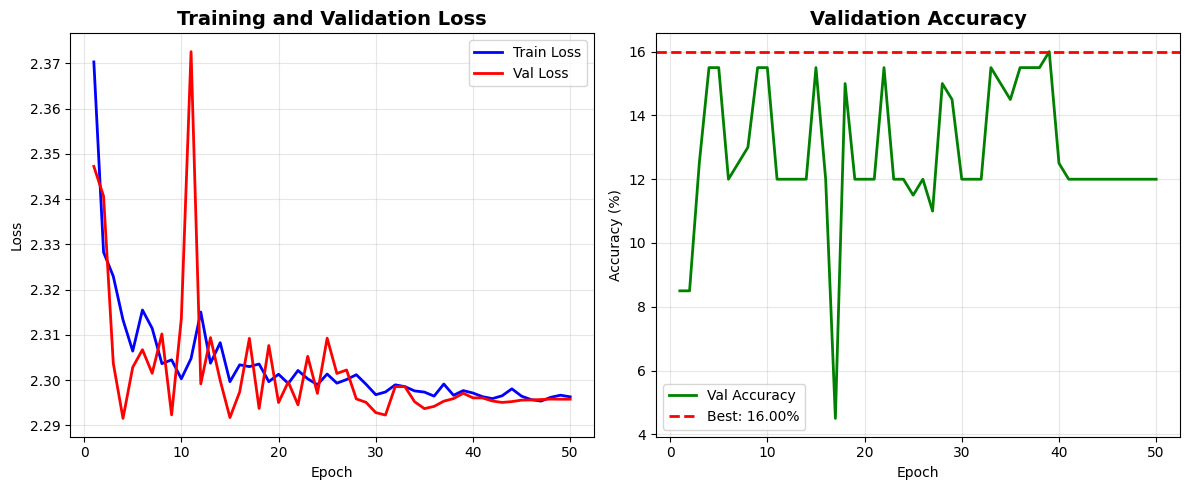

📊 Training curves saved to: training_curves.png

🏆 9. Final Results Summary:
🥇 Best validation accuracy: 16.00%
📉 Final training loss: 2.2963
📉 Final validation loss: 2.2958
🎉 Training pipeline completed successfully!


In [ ]:
# 8. Plot training curves
print(f"\n📈 8. Generating training curves...")
plot_training_curves(training_metrics, 'training_curves.png')

# 9. Final results summary
print(f"\n🏆 9. Final Results Summary:")
print("=" * 50)
print(f"🥇 Best validation accuracy: {training_metrics['best_acc']:.2f}%")
print(f"📉 Final training loss: {training_metrics['train_losses'][-1]:.4f}")
print(f"📉 Final validation loss: {training_metrics['val_losses'][-1]:.4f}")

# 10. Log final metrics to wandb
if config['use_wandb']:
    try:
        wandb.log({
            'final/best_acc': training_metrics['best_acc'],
            'final/final_train_loss': training_metrics['train_losses'][-1],
            'final/final_val_loss': training_metrics['val_losses'][-1]
        })

        # Log training curves as images
        if os.path.exists('training_curves.png'):
            wandb.log({"training_curves": wandb.Image('training_curves.png')})

        if os.path.exists('model_architecture.png'):
            wandb.log({"model_architecture": wandb.Image('model_architecture.png')})
    except Exception:
        # Ignore wandb errors if not properly initialized
        print("⚠️ Wandb logging skipped due to initialization issues")

print("=" * 50)
print("🎉 Training pipeline completed successfully!")


## 🧪 14. Testarea Modelului Final

Testarea modelului antrenat și demonstrarea inferenței.


In [ ]:
# 10. Test the trained model
print("\n🧪 10. Testing the trained model...")

# Load best checkpoint
best_checkpoint_path = os.path.join(config['save_dir'], 'best_checkpoint.pth')
if os.path.exists(best_checkpoint_path):
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Loaded best model with accuracy: {checkpoint['best_acc']:.2f}%")
else:
    print("⚠️ No best checkpoint found, using current model state")

# Test inference
model.eval()
test_images, test_labels = next(iter(val_loader))
test_images = test_images.to(device)
test_labels = test_labels.to(device)

with torch.no_grad():
    outputs = model(test_images)
    _, predicted = torch.max(outputs, 1)

    # Calculate accuracy for this batch
    batch_accuracy = (predicted == test_labels).float().mean().item() * 100

    print(f"\n🔍 Test batch results:")
    print(f"📊 Batch accuracy: {batch_accuracy:.2f}%")
    print(f"🎯 Predictions: {predicted[:8].cpu().tolist()}")
    print(f"✅ Ground truth: {test_labels[:8].cpu().tolist()}")

# Show confidence scores for first few samples
probabilities = F.softmax(outputs[:5], dim=1)
confidences, pred_classes = torch.max(probabilities, 1)

print(f"\n🎯 Confidence scores for first 5 samples:")
for i in range(5):
    confidence_percent = confidences[i].item() * 100
    print(f"  Sample {i+1}: Class {pred_classes[i].item()} with {confidence_percent:.1f}% confidence")


🧪 10. Testing the trained model...
✅ Loaded best model with accuracy: 16.00%

🔍 Test batch results:
📊 Batch accuracy: 12.50%
🎯 Predictions: [8, 8, 8, 8, 8, 8, 8, 8]
✅ Ground truth: [9, 5, 2, 7, 9, 0, 3, 2]

🎯 Confidence scores for first 5 samples:
  Sample 1: Class 8 with 12.2% confidence
  Sample 2: Class 8 with 12.1% confidence
  Sample 3: Class 8 with 12.2% confidence
  Sample 4: Class 8 with 12.1% confidence
  Sample 5: Class 8 with 12.2% confidence


## 🎉 15. Sumar Final și Pași Următori

Închiderea experimentului și sugestii pentru continuare.


In [ ]:
# Finish wandb run
if config['use_wandb']:
    try:
        wandb.finish()
        print("🌐 Wandb run finished")
    except Exception:
        print("⚠️ Wandb finish skipped due to initialization issues")

# Print final summary
print("\n" + "=" * 60)
print("🎉 MambaVision Training Complete!")
print("=" * 60)
print(f"✅ Model: {config['model_size']} MambaVision ({total_params:,} parameters)")
print(f"✅ Dataset: {config['dataset_size']} synthetic samples")
print(f"✅ Training: {config['epochs']} epochs completed")
print(f"✅ Best accuracy: {training_metrics['best_acc']:.2f}%")

print("\n🙏 Thank you for using MambaVision!")



🌐 Wandb run finished

🎉 MambaVision Training Complete!
✅ Model: tiny MambaVision (2,112,586 parameters)
✅ Dataset: 1000 synthetic samples
✅ Training: 50 epochs completed
✅ Best accuracy: 16.00%

🙏 Thank you for using MambaVision!


In [ ]:
# Install torchview for model visualization
print("📦 Installing torchview and graphviz...")

# Install packages
import subprocess
import sys

try:
    # Install torchview
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'torchview', '--quiet'])
    print("✅ torchview installed successfully!")

    # Try to install graphviz (pentru vizualizări mai avansate)
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'graphviz', '--quiet'])
        print("✅ graphviz installed successfully!")
    except:
        print("⚠️ graphviz could not be installed, but torchview will still work with basic features")

except Exception as e:
    print(f"❌ Installation failed: {e}")
    print("💡 You can install manually with: pip install torchview graphviz")

print("\n🎯 Ready for model visualization!")


📦 Installing torchview and graphviz...
✅ torchview installed successfully!
✅ graphviz installed successfully!

🎯 Ready for model visualization!


In [ ]:
# Simple TorchView visualization setup
try:
    from torchview import draw_graph
    print("✅ TorchView imported successfully!")
    torchview_available = True

except ImportError as e:
    print(f"❌ Could not import torchview: {e}")
    print("💡 Install with: pip install torchview")
    torchview_available = False


✅ TorchView imported successfully!


🎨 Creating MambaVision architecture visualization...
✅ Model visualization created!
📁 Saved as 'mambavision_architecture.png'


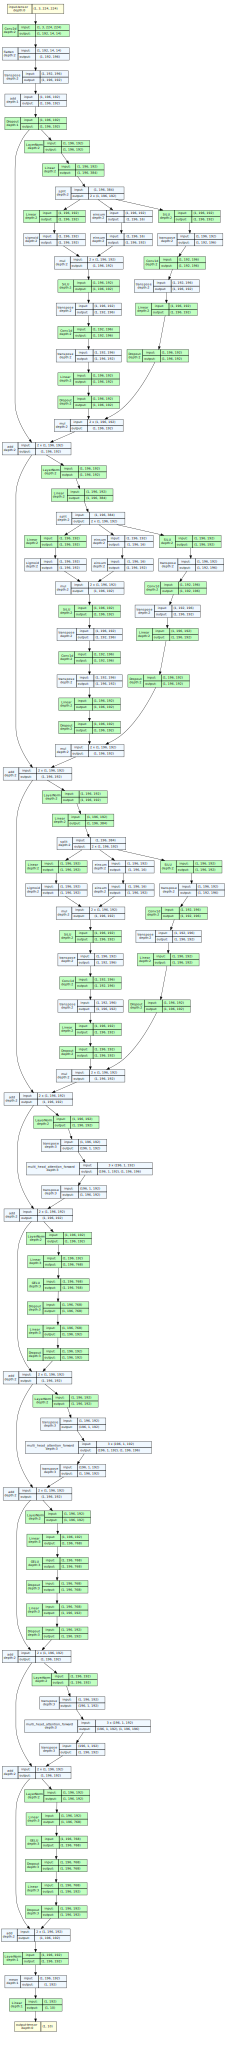

In [ ]:
# Simple Model Visualization
if torchview_available:
    print("🎨 Creating MambaVision architecture visualization...")

    try:
        # Use existing model or create new one
        model_to_viz = create_mambavision_tiny(num_classes=10)
        model_to_viz.eval()

        # Simple visualization
        model_graph = draw_graph(
            model_to_viz,
            input_size=(1, 3, 224, 224),
            depth=3,
            device='cpu',
            hide_module_functions=True,
            hide_inner_tensors=True,
            show_shapes=True,
            save_graph=True,
            filename='mambavision_architecture'
        )

        print("✅ Model visualization created!")
        print("📁 Saved as 'mambavision_architecture.png'")

        # Display
        display(model_graph.visual_graph)

    except Exception as e:
        print(f"❌ Error: {e}")
        print("💡 Try: pip install graphviz and install system graphviz")

else:
    print("⚠️ Install torchview first: pip install torchview")


In [ ]:
from google.colab import files
files.download("/content/mambavision_architecture.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>